In [1]:
# %%
# Sanity check: print environment info
import os, sys, time, platform

print("python:", sys.version.split()[0])
print("executable:", sys.executable)
print("pid:", os.getpid())
print("platform:", platform.platform())
print("cwd:", os.getcwd())
time.sleep(0.1)
print("kernel ok")

python: 3.12.3
executable: /home/seancm/code/python_analytics_practice/.venv/bin/python
pid: 16979
platform: Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
cwd: /home/seancm/code/python_analytics_practice/Problem 3/analysis
kernel ok


In [2]:
import sys
from pathlib import Path
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
pd.set_option("display.max_rows", 200)

sns.set_theme(style="whitegrid", palette="muted")
sns.set_context("notebook")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("Python:", sys.version)


Python: 3.12.3 (main, Jan  8 2026, 11:30:50) [GCC 13.3.0]


In [3]:
# %%
# Paths
# If running as a notebook (no __file__), fallback to cwd.
try:
    ANALYSIS_DIR = Path(__file__).resolve().parent
except NameError:
    ANALYSIS_DIR = Path.cwd()

PROJECT_ROOT = ANALYSIS_DIR.parent
RAW_DIR = PROJECT_ROOT / "raw_data"
CLEAN_DIR = PROJECT_ROOT / "clean_data"
OUTPUT_DIR = PROJECT_ROOT / "output"

for d in [RAW_DIR, CLEAN_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("RAW_DIR:", RAW_DIR)
print("CLEAN_DIR:", CLEAN_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

PROJECT_ROOT: /home/seancm/code/python_analytics_practice/Problem 3
RAW_DIR: /home/seancm/code/python_analytics_practice/Problem 3/raw_data
CLEAN_DIR: /home/seancm/code/python_analytics_practice/Problem 3/clean_data
OUTPUT_DIR: /home/seancm/code/python_analytics_practice/Problem 3/output


In [4]:
df = pd.read_csv(
    RAW_DIR / "airwallex_revenue_forecast_synth.csv"
)  # <- replace if needed
df.head()

,date,revenue_usd,marketing_index,fx_volatility_index
0,2022-01-01,2.064011e+06,0.803839,0.877130
1,2022-01-02,2.384251e+06,1.038245,0.855052
2,2022-01-03,2.528661e+06,0.763211,0.750523
3,2022-01-04,2.879095e+06,0.978474,0.815448
4,2022-01-05,3.030988e+06,0.847175,0.795175


In [5]:
# %%
def df_overview(df: pd.DataFrame, n: int = 5) -> None:
    print("Shape:", df.shape)
    display(df.head(n))  # type: ignore
    print("\nDtypes:\n", df.dtypes)
    print(
        "\nMissingness (%):\n",
        (df.isna().mean() * 100).sort_values(ascending=False).head(30),
    )
    print("\nDuplicate rows:", df.duplicated().sum())


df_overview(df)

Shape: (900, 4)


,date,revenue_usd,marketing_index,fx_volatility_index
0,2022-01-01,2.064011e+06,0.803839,0.877130
1,2022-01-02,2.384251e+06,1.038245,0.855052
2,2022-01-03,2.528661e+06,0.763211,0.750523
3,2022-01-04,2.879095e+06,0.978474,0.815448
4,2022-01-05,3.030988e+06,0.847175,0.795175



Dtypes:
 date                    object
revenue_usd            float64
marketing_index        float64
fx_volatility_index    float64
dtype: object

Missingness (%):
 date                   0.0
revenue_usd            0.0
marketing_index        0.0
fx_volatility_index    0.0
dtype: float64

Duplicate rows: 0


# %% [markdown]
# ## Dataset
#
# **Granularity:** Daily time series
# **Time span:** ~2.5 years
#
# **Columns:**
# - `date` (datetime): calendar date
# - `revenue_usd` (float): total daily revenue in USD
# - `marketing_index` (float): proxy for marketing intensity
# - `fx_volatility_index` (float): proxy for FX market conditions


# %% [markdown]
# ## Target Variable
#
# **Primary target:** `revenue_usd`
#
# Depending on modeling choice, revenue may be modeled:
# - in raw USD terms, or
# - on a log scale to stabilize variance and model multiplicative effects
# ## Problem Statement
#
# Revenue is influenced by:
# - long-term growth trends
# - weekly and annual seasonality
# - external drivers such as marketing activity and FX conditions
#
# In addition, a potential policy or tariff change may have introduced
# a structural shift in revenue at some point in the historical data.
#
# The task is to disentangle these effects and produce reliable forecasts.

# %% [markdown]
# ## Analysis Goals
#
# 1. Identify and model trend and seasonality in revenue
# 2. Incorporate external drivers into the forecasting model
# 3. Estimate the direction and magnitude of any policy-related impact
# 4. Generate forward-looking revenue forecasts with uncertainty
# 5. Communicate results clearly for business decision-making
#
# ## What Success Looks Like
#
# **Technical:**
# - Reasonable forecast accuracy on held-out future periods
# - Well-calibrated prediction intervals
#
# **Business:**
# - Errors within an acceptable tolerance (≈3–5% at medium horizons)
# - Clear explanation of assumptions and risks
# - Actionable insights for planning and scenario analysis

In [6]:
# %%

def prepare_features(
    df: pd.DataFrame,
    *,
    date_col: str = "date",
    revenue_col: str = "revenue_usd",
    add_log: bool = True,
    log_col: str = "revenue_usd_log",
    log_mode: str = "auto",   # "log", "log1p", or "auto" (but avoid auto once training starts)
    t0: pd.Timestamp | str | None = None,  # fixed origin for t
    t_col: str = "t",
    weekend_col: str = "is_weekend",
    period_days: float = 365.25,
    harmonics: int = 2,
    tau: pd.Timestamp | str | None = None,  # break date
    break_col: str = "break_term",
    drop_duplicate_dates: bool = True,
    check_gaps: bool = False,
    copy: bool = True,
) -> pd.DataFrame:
    """
    Prepare a clean, reproducible feature set for time-series modelling.

    Adds (by default):
      - log revenue (log_col)
      - time index in days since t0 (t_col)
      - weekend indicator (weekend_col)
      - Fourier seasonality terms: sin_1y_1, cos_1y_1, ..., sin_1y_k, cos_1y_k
      - optional hinge break term: break_col = max(0, t - t_tau)

    Forecast safety:
      - If t0 is provided, t is pinned to that origin for both training and future dates.
      - If tau is provided, break term is computed relative to that same t0.
      - log_mode should be fixed ("log" or "log1p") once training starts.
    """
    d = df.copy() if copy else df

    # --- Validate and standardize date column ---
    if date_col not in d.columns:
        raise ValueError(f"Missing required column: {date_col}")

    d[date_col] = pd.to_datetime(d[date_col]).dt.normalize()
    d = d.sort_values(date_col)

    if drop_duplicate_dates:
        d = d.drop_duplicates(subset=[date_col], keep="first")

    # --- Time origin (t0) ---
    if t0 is None:
        t0_ts = d[date_col].min()
    else:
        t0_ts = pd.to_datetime(t0).normalize()

    # --- Time index (days since t0) ---
    d[t_col] = (d[date_col] - t0_ts).dt.total_seconds() / (24 * 3600)

    # --- Weekend flag ---
    d[weekend_col] = d[date_col].dt.dayofweek >= 5

    # --- Optional break term (hinge / sharp slope break) ---
    if tau is not None:
        
        tau_ts = pd.to_datetime(tau).normalize()
        if tau_ts < t0_ts:
            raise ValueError("tau must be on or after t0")
        t_tau = (tau_ts - t0_ts).total_seconds() / (24 * 3600)
        d[break_col] = np.maximum(0.0, d[t_col] - t_tau)

    # --- Log revenue (variance stabilization / multiplicative effects) ---
    if add_log:
        if revenue_col not in d.columns:
            raise ValueError(f"Missing required column for log transform: {revenue_col}")

        if log_mode not in {"log", "log1p", "auto"}:
            raise ValueError(f"log_mode must be one of 'log', 'log1p', 'auto' (got {log_mode!r})")

        if log_mode == "auto":
            # OK for exploration, but NOT for final training/forecasting
            use_log1p = (d[revenue_col] <= 0).any()
        else:
            use_log1p = (log_mode == "log1p")

        if use_log1p:
            if (d[revenue_col] < 0).any():
                raise ValueError("Negative revenue values found; log/log1p undefined.")
            d[log_col] = np.log1p(d[revenue_col])
        else:
            if (d[revenue_col] <= 0).any():
                raise ValueError("Non-positive revenue values found; use log1p or clean data.")
            d[log_col] = np.log(d[revenue_col])

    # --- Fourier seasonality terms (annual) ---
    for k in range(1, harmonics + 1):
        angle = 2.0 * np.pi * k * d[t_col] / period_days
        d[f"sin_1y_{k}"] = np.sin(angle)
        d[f"cos_1y_{k}"] = np.cos(angle)

    # --- Sanity checks ---
    if not d[date_col].is_monotonic_increasing:
        raise ValueError("Dates are not sorted/monotonic after preparation (unexpected).")

    # Optional: gaps check (off by default to avoid noisy prints)
    if check_gaps:
        expected = pd.date_range(d[date_col].min(), d[date_col].max(), freq="D")
        missing_dates = expected.difference(d[date_col])
        if len(missing_dates) > 0:
            print(f"Warning: {len(missing_dates)} missing dates (series has gaps).")
    # Note - | here means set union rather than bitwise or. 
    expected_fourier = {f"sin_1y_{k}" for k in range(1, harmonics + 1)} | {
        f"cos_1y_{k}" for k in range(1, harmonics + 1)
    }
    actual_fourier = {c for c in d.columns if c.startswith(("sin_1y_", "cos_1y_"))}

    missing = expected_fourier - actual_fourier
    extra = actual_fourier - expected_fourier
    if missing:
        raise ValueError(f"Missing Fourier columns: {missing}")
    if extra:
        print(f"Warning: extra Fourier columns present: {extra}")

    fourier_cols = sorted(actual_fourier)
    if not np.isfinite(d[fourier_cols].to_numpy()).all():
        raise ValueError("Non-finite values found in Fourier features (unexpected).")

    return d

In [7]:
# %%
state = {
    "t0": pd.to_datetime(df["date"]).min().normalize(),
    "tau": None,
    "log_mode": "log",
}

In [9]:
# %%
# Fit a regression model predicting USD from date, day of week, and
# month of the year. This will help quantify the effects.
import statsmodels.api as sm
from statsmodels.formula.api import ols

# %% [markdown]
### Detecting an Unknown Trend Break (Single Structural Break)

## Objective
# We want to test whether there is evidence of a structural change in the
# revenue growth rate (e.g. due to a policy or regulatory change), without
# assuming in advance when (or if) such a change occurred.

## Baseline model
# We begin with a well-specified baseline model that already explains most
# systematic variation in revenue:
# - Linear time trend
# - Weekend effects
# - Annual seasonality (Fourier terms)
#
# Any detected break should therefore represent new structure not already
# captured by trend or seasonality.

## Break model (slope change)
# We allow the slope of the time trend to change at an unknown breakpoint τ
# using a hinge (ramp) function:
#
#   hinge_t(τ) = max(0, t − τ)
#
# The regression becomes:
#   log(revenue_t) = baseline + β·t + δ·hinge_t(τ) + error
#
## Interpretation:
# - β: pre-break growth rate
# - β + δ: post-break growth rate
# - δ: change in growth rate after the break

## Estimating the break date
# Because τ is unknown, we perform a grid search over candidate break dates:
# - Exclude the first and last N days to ensure data on both sides
# - Evaluate candidate τ values at regular intervals (e.g. weekly)
# - Fit the model for each τ and record a penalised fit metric (BIC)

## Model selection
# The breakpoint τ that minimises BIC is selected.
# BIC is used to penalise unnecessary complexity and reduce the risk of
# detecting spurious breaks driven by noise.

## Outputs
# This procedure yields:
# - An estimated break date
# - Pre- and post-break growth rates
# - Statistical evidence for a change in slope
# - Diagnostic plots (BIC vs τ, fitted piecewise trend)

## Rationale
# This approach is interpretable, conservative, and well-suited to identifying
# potential policy-driven changes in growth without overfitting.

In [10]:
# %%

# Define a series of functions to perform and plot grid search finding a single breakpoint
# in the trend.

# -----------------------------
# Single-break grid search (slope break) with a hinge term
# y ~ baseline + delta * max(0, t - tau)
# -----------------------------


def single_break_grid_search(
    df,
    date_col="date",
    y_col="revenue_usd_log",
    t_col="t",
    baseline_terms=None,
    min_side_days=120,  # exclude first/last N days as candidate breaks
    step_days=7,  # evaluate candidate break every 7 days (speeds up)
    criterion="bic",  # "bic" (default) or "aic" or "rss"
):
    """
    Grid-search an unknown single breakpoint tau for a *slope change* model.

    Model form:
      y = baseline + beta * t + delta * hinge_tau + error
    where:
      hinge_tau = max(0, t - t_tau)

    Returns:
      results_df: one row per candidate tau with criterion + params
      best_tau_date: selected break date (Timestamp)
      best_model: fitted statsmodels regression for the best tau
    """

    df = prepare_features(df)

    # Ensure time index exists
    # if t_col not in df.columns:
    #     df[t_col] = (df[date_col] - df[date_col].min()).dt.days.astype(float)

    # Default baseline: your current spec (adjust if your column names differ)
    if baseline_terms is None:
        baseline_terms = [
            f"{t_col}",
            "is_weekend",
            "sin_1y_1",
            "cos_1y_1",
            "sin_1y_2",
            "cos_1y_2",
        ]

    # Build the core formula without hinge (we'll add hinge_tau each iteration)
    base_formula = f"{y_col} ~ " + " + ".join(baseline_terms)

    # Candidate tau dates: exclude edges so we have data on both sides
    dates = df[date_col]
    min_date = dates.min() + pd.Timedelta(days=min_side_days)
    max_date = dates.max() - pd.Timedelta(days=min_side_days)

    # Use a spaced grid of candidate dates
    cand_dates = pd.date_range(min_date, max_date, freq=f"{step_days}D")
    if len(cand_dates) < 5:
        raise ValueError(
            "Not enough candidate break dates. Reduce min_side_days or step_days."
        )

    rows = []

    for tau_date in cand_dates:
        # tau in t-units (days since start)
        tau_t = float(df.loc[df[date_col] <= tau_date, t_col].max())

        # Hinge term: (t - tau_t) if t > tau_t else 0
        hinge = np.maximum(0.0, df[t_col].to_numpy() - tau_t)
        df["_hinge"] = hinge

        # Fit model with hinge
        m = ols(base_formula + " + _hinge", data=df).fit()

        # Choose objective
        if criterion == "bic":
            score = m.bic
        elif criterion == "aic":
            score = m.aic
        elif criterion == "rss":
            score = np.sum(m.resid**2)
        else:
            raise ValueError("criterion must be one of: 'bic', 'aic', 'rss'")

        beta_pre = m.params.get(t_col, np.nan)
        delta = m.params.get("_hinge", np.nan)
        beta_post = beta_pre + delta

        rows.append(
            {
                "tau_date": tau_date,
                "tau_t": tau_t,
                criterion: score,
                "beta_pre": beta_pre,
                "delta_slope": delta,
                "beta_post": beta_post,
                "p_delta": m.pvalues.get("_hinge", np.nan),
                "r2": m.rsquared,
            }
        )

    results_df = pd.DataFrame(rows).sort_values(criterion).reset_index(drop=True)

    # Best tau
    best_tau_date = results_df.loc[0, "tau_date"]
    best_tau_t = results_df.loc[0, "tau_t"]

    # Refit best model (cleanly) and return it
    df["_hinge"] = np.maximum(0.0, df[t_col].to_numpy() - best_tau_t)
    best_model = ols(base_formula + " + _hinge", data=df).fit()

    return results_df, best_tau_date, best_model


# -----------------------------
# Helper: plot criterion over tau dates + optional fitted trend overlay
# -----------------------------


def plot_break_search(results_df, criterion="bic"):
    plt.figure(figsize=(14, 5))
    plt.plot(results_df["tau_date"], results_df[criterion], marker="o", linewidth=1)
    best_idx = results_df[criterion].idxmin()
    best_tau = results_df.loc[best_idx, "tau_date"]
    plt.axvline(best_tau, linestyle="--")
    plt.title(f"Single-break grid search: {criterion.upper()} vs candidate break date")
    plt.xlabel("Candidate break date (tau)")
    plt.ylabel(criterion.upper())
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Best break date (BIC): 2023-04-23
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.7025      0.009   1573.106      0.000      14.684      14.721
is_weekend[T.True]    -0.1983      0.008    -26.295      0.000      -0.213      -0.183
t                      0.0006   2.81e-05     19.843      0.000       0.001       0.001
sin_1y_1               0.2016      0.005     39.956      0.000       0.192       0.211
cos_1y_1               0.2383      0.005     48.249      0.000       0.229       0.248
sin_1y_2              -0.0696      0.005    -14.163      0.000      -0.079      -0.060
cos_1y_2              -0.0203      0.005     -4.162      0.000      -0.030      -0.011
_hinge                -0.0004   5.46e-05     -6.511      0.000      -0.000      -0.000


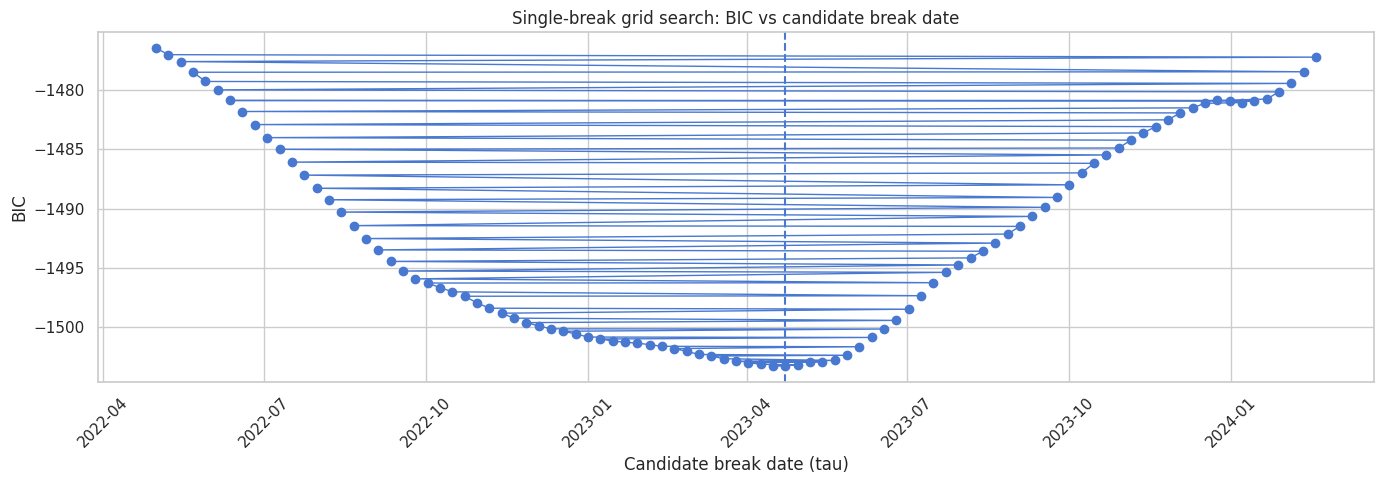

In [11]:
# %%
# Run the single-break grid search and plot results
# Set break_col to _hinge to match what we set it to in the grid search
df = prepare_features(df, **state, break_col = '_hinge')
from statsmodels.formula.api import ols
results_df, best_tau_date, best_model = single_break_grid_search(
    df=df,
    min_side_days=120,  # you can try 90 or 150 as sensitivity checks
    step_days=7,  # 7 = weekly grid; 1 = daily grid (slower)
    criterion="bic",
)

print("Best break date (BIC):", best_tau_date.date())
print(best_model.summary().tables[1])  # coefficient table

plot_break_search(results_df, criterion="bic")

# best_tau_t = (pd.to_datetime(best_tau_date).normalize() - state["t0"]).days
# Update the state dict with the best tau_date so next time we run prepare_features we'll 
# compute a break column
state["tau"] = best_tau_date


In [12]:
# %%
baseline_model = ols(
    "revenue_usd_log ~ t + is_weekend + sin_1y_1 + cos_1y_1 + sin_1y_2 + cos_1y_2",
    data=df,
).fit()

print("Baseline BIC:", baseline_model.bic)
print("Break model BIC:", best_model.bic)
print("ΔBIC (baseline − break):", baseline_model.bic - best_model.bic)


Baseline BIC: -1468.2764857058123
Break model BIC: -1503.2601974341821
ΔBIC (baseline − break): 34.983711728369826


In [13]:
# %% 
results_df.head()

,tau_date,tau_t,bic,beta_pre,delta_slope,beta_post,p_delta,r2
0,2023-04-23,477.0,-1503.260197,0.000559,-0.000356,0.000203,1.245944e-10,0.865379
1,2023-04-16,470.0,-1503.235600,0.000562,-0.000354,0.000208,1.261571e-10,0.865375
2,2023-04-30,484.0,-1503.183212,0.000555,-0.000357,0.000198,1.295510e-10,0.865368
3,2023-04-09,463.0,-1503.117527,0.000565,-0.000353,0.000213,1.339359e-10,0.865358
4,2023-04-02,456.0,-1502.978203,0.000569,-0.000352,0.000217,1.437346e-10,0.865337


In [14]:
# %%
# We use the definition that a change of <2 in BIC is not meaningful 
# evidence (bayes factor of ~3:1 or less). See e.g. Kass & Raftery (1995)
best_bic = results_df['bic'].min()
mask = results_df['bic'] <= best_bic + 2.0
earliest_date = results_df.loc[mask, 'tau_date'].min()
latest_date = results_df.loc[mask, 'tau_date'].max()
print(f"BIC within 2 of best ({best_bic:.2f}) for break dates between {earliest_date.date()} and {latest_date.date()}")


BIC within 2 of best (-1503.26) for break dates between 2023-01-22 and 2023-06-04


In [15]:
# %%
def overlay_baseline_vs_break(
    df,
    baseline_model,
    break_model,
    *,
    state: dict,
    date_col: str = "date",
    y_col: str = "revenue_usd_log",
    title: str = "Fitted log revenue: baseline vs single-break model",
    break_col: str = "_hinge",
):
    """
    Plot actual y plus fitted values from:
      - baseline_model (no break_term)
      - break_model (with break_term)
    Assumes `state` contains at least t0/log_mode and (optionally) tau.
    """

    # --- Build features WITHOUT break for baseline predictions ---
    state_no_tau = dict(state)
    state_no_tau["tau"] = None
    d_base = prepare_features(df, **state_no_tau)

    # Baseline predictions (must match the model's design columns)
    d_base["_yhat_base"] = baseline_model.predict(d_base)

    # --- Build features WITH break for break-model predictions ---
    d_break = prepare_features(df, **state, break_col=break_col)

    # Break predictions (only valid if tau is set)
    if state.get("tau") is None:
        raise ValueError("state['tau'] is None; cannot plot break model overlay.")

    if break_col not in d_break.columns:
        raise ValueError(f"Expected break column {break_col!r} not found in features.")

    d_break["_yhat_break"] = break_model.predict(d_break)

    # --- Plot ---
    plt.figure(figsize=(14, 6))
    plt.plot(d_break[date_col], d_break[y_col], alpha=0.25, label="Actual (log revenue)")
    plt.plot(d_base[date_col], d_base["_yhat_base"], linewidth=2, label="Fitted: baseline")

    plt.plot(
        d_break[date_col],
        d_break["_yhat_break"],
        linewidth=2,
        alpha=0.6,
        label="Fitted: break (piecewise slope)",
    )

    tau_date = state["tau"]
    plt.axvline(tau_date, linestyle="--", label=f"Break: {pd.to_datetime(tau_date).date()}")

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Log revenue")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # return d  # handy if you want to inspect the fitted columns


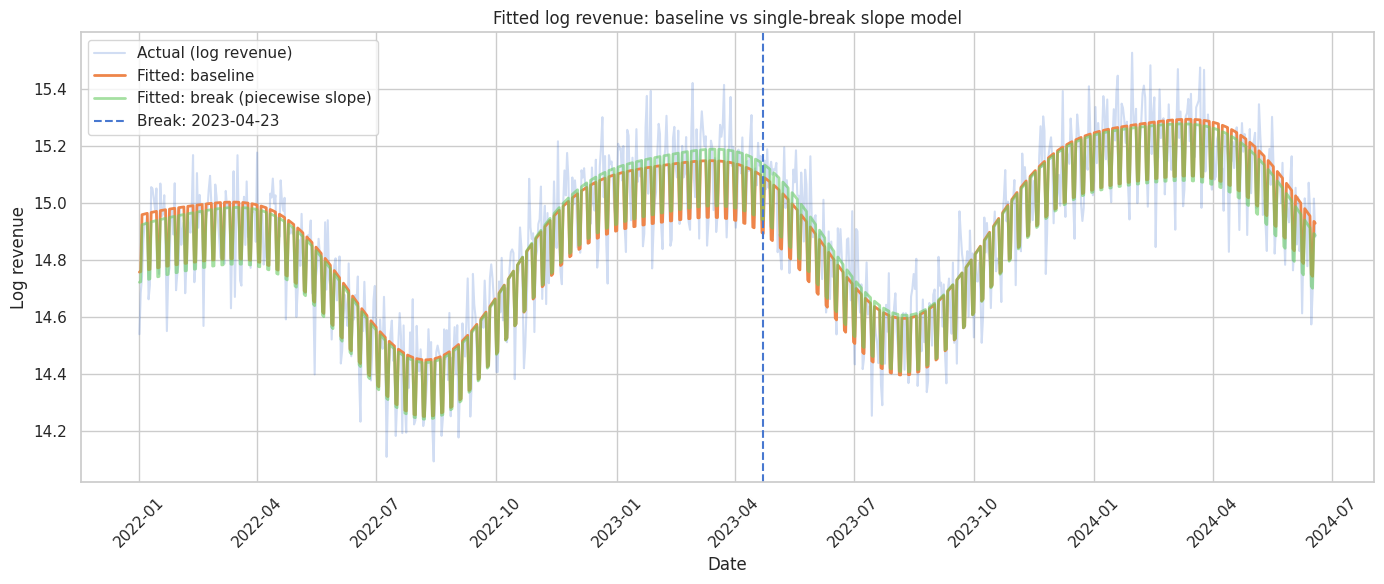

In [16]:
# %%
best_idx = results_df['bic'].idxmin()
best_tau_t = results_df.loc[best_idx, "tau_t"]
overlay_baseline_vs_break(
    df,
    baseline_model,
    break_model = best_model,
    state=state,
    title="Fitted log revenue: baseline vs single-break slope model",
)


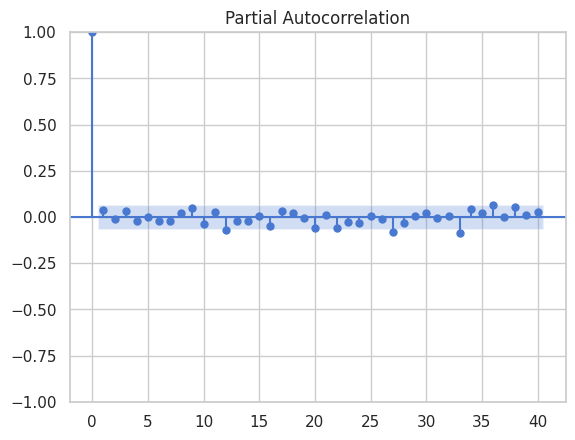

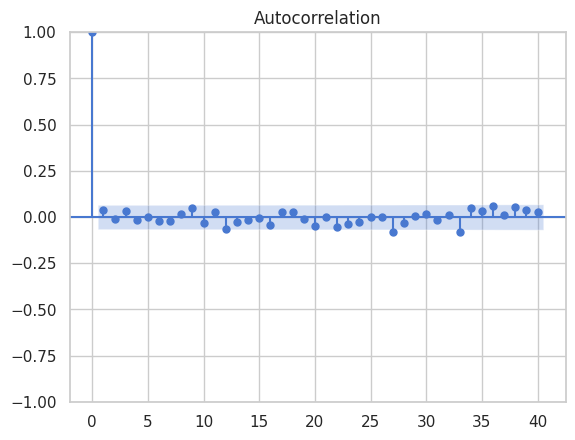

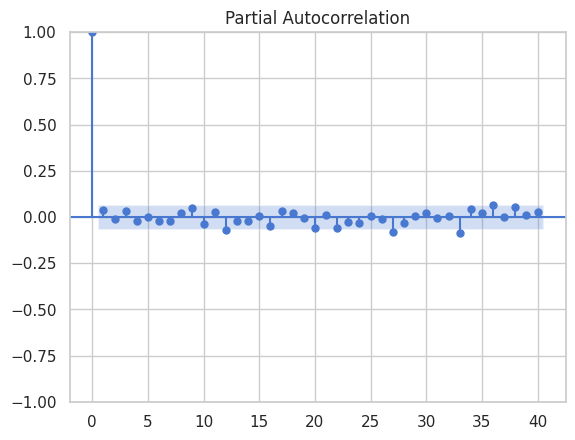

In [17]:

# %%
# Explore residual autocorrelation to see if our model capture everything.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

resid = best_model.resid

plot_acf(resid, lags=40)
plot_pacf(resid, lags=40)


In [18]:
# %%

# Lock in feature and outcome cols, split the data, prepare for forecasting
df_feat = prepare_features(df, **state)

y_col = "revenue_usd_log"

feature_cols = [
    "t",
    "is_weekend",
    "sin_1y_1", "cos_1y_1",
    "sin_1y_2", "cos_1y_2",
    "break_term",
]

X_train = df_feat[feature_cols]
y_train = df_feat[y_col]

# We have to manually add a constant column for statsmodels or else the 
# model will be fited to pass a line through (0, 0) which is very bad in log space. 
X_train = sm.add_constant(X_train.astype(float), has_constant="add")

X_train = X_train.astype(float)   # bool -> 0/1
y_train = y_train.astype(float)

print("X dtypes:\n", X_train.dtypes)
print("y dtype:", y_train.dtype)

print("Any NaNs in X?", X_train.isna().any().any())
print("Any NaNs in y?", y_train.isna().any())

print("Any inf in X?", np.isinf(X_train.to_numpy()).any())
print("Any inf in y?", np.isinf(y_train.to_numpy()).any())

X dtypes:
 const         float64
t             float64
is_weekend    float64
sin_1y_1      float64
cos_1y_1      float64
sin_1y_2      float64
cos_1y_2      float64
break_term    float64
dtype: object
y dtype: float64
Any NaNs in X? False
Any NaNs in y? False
Any inf in X? False
Any inf in y? False


In [19]:
# %%
# Fit the final model. We don't have to specify a model formula, because we've split the X and
# y dataframes already.
import statsmodels.api as sm

model = sm.OLS(y_train, X_train)
results = model.fit()

print(results.summary())
# %%

# Create future dates dataframe
last_date = df["date"].max()
horizon = 366

future_df = pd.DataFrame({
    "date": pd.date_range(
        last_date + pd.Timedelta(days=1),
        periods=horizon,
        freq="D",
    )
})

                            OLS Regression Results                            
Dep. Variable:        revenue_usd_log   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     819.1
Date:                Mon, 02 Feb 2026   Prob (F-statistic):               0.00
Time:                        16:02:05   Log-Likelihood:                 778.84
No. Observations:                 900   AIC:                            -1542.
Df Residuals:                     892   BIC:                            -1503.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7025      0.009   1573.106      0.0

In [44]:
# Get a summary of model parameters from an OLS object
def summarize_ols_model(ols_results: sm.regression.linear_model.RegressionResultsWrapper) -> pd.DataFrame:
    """
    Summarize key parameters from a fitted statsmodels OLS regression results object.
    """
    params = ols_results.params
    bse = ols_results.bse
    tvalues = ols_results.tvalues
    pvalues = ols_results.pvalues
    conf_int = ols_results.conf_int()

    summary_df = pd.DataFrame({
        "coef": params,
        "std_err": bse,
        "t_value": tvalues,
        "p_value": pvalues,
        "conf_low": conf_int[0],
        "conf_high": conf_int[1],
    })

    return summary_df

summarize_ols_model(results)

,coef,std_err,t_value,p_value,conf_low,conf_high
const,14.702480,0.009346,1573.106036,0.000000e+00,14.684137,14.720823
t,0.000559,0.000028,19.842724,7.309480e-73,0.000503,0.000614
is_weekend,-0.198290,0.007541,-26.295248,2.794686e-113,-0.213090,-0.183490
sin_1y_1,0.201567,0.005045,39.955590,6.327674e-201,0.191666,0.211468
cos_1y_1,0.238314,0.004939,48.248798,7.229528e-251,0.228620,0.248008
sin_1y_2,-0.069642,0.004917,-14.163332,3.173986e-41,-0.079293,-0.059992
cos_1y_2,-0.020305,0.004879,-4.161576,3.466600e-05,-0.029880,-0.010729
break_term,-0.000356,0.000055,-6.510849,1.245944e-10,-0.000463,-0.000248


In [48]:
# Model the growth rate as percentages both before and after the break
beta_t = summarize_ols_model(results).loc['t']['coef']
beta_break = summarize_ols_model(results).loc['break_term']['coef']

pre_daily = beta_t
post_daily = beta_t + beta_break

pre_annual = np.expm1(365 * pre_daily)
post_annual = np.expm1(365 * post_daily)

print(f"Pre-break annual growth:  {pre_annual:.1%}")
print(f"Post-break annual growth: {post_annual:.1%}")
print(f"Slowdown in annual growth: {((post_annual - pre_annual) / pre_annual * 100):.1f}%")


Pre-break annual growth:  22.6%
Post-break annual growth: 7.7%
Slowdown in annual growth: -66.0%


In [20]:
# %%
future_feat = prepare_features(
    future_df,
    **state,
    add_log=False,
)


X_future = future_feat[feature_cols].astype(float)
X_future = sm.add_constant(X_future.astype(float), has_constant="add")

assert list(X_future.columns) == list(X_train.columns)
print("X and X future columns aligned")
X_future.head()


X and X future columns aligned


,const,t,is_weekend,sin_1y_1,cos_1y_1,sin_1y_2,cos_1y_2,break_term
0,1.0,900.0,0.0,0.223868,-0.974619,-0.436373,0.899766,423.0
1,1.0,901.0,0.0,0.207070,-0.978326,-0.405165,0.914244,424.0
2,1.0,902.0,0.0,0.190211,-0.981743,-0.373477,0.927640,425.0
3,1.0,903.0,1.0,0.173295,-0.984870,-0.341347,0.939938,426.0
4,1.0,904.0,1.0,0.156328,-0.987705,-0.308812,0.951123,427.0


In [22]:
# %% 
print("X_train cols:", list(X_train.columns))
print("X_future cols:", list(X_future.columns))
print("Same columns?", list(X_train.columns) == list(X_future.columns))
print("Train shape:", X_train.shape, "Future shape:", X_future.shape)

feature_cols = X_train.columns.tolist()
X_future = X_future.reindex(columns=feature_cols).astype(float)

if X_future.isna().any().any():
    raise ValueError("Missing feature columns in X_future after reindex.")


X_train cols: ['const', 't', 'is_weekend', 'sin_1y_1', 'cos_1y_1', 'sin_1y_2', 'cos_1y_2', 'break_term']
X_future cols: ['const', 't', 'is_weekend', 'sin_1y_1', 'cos_1y_1', 'sin_1y_2', 'cos_1y_2', 'break_term']
Same columns? True
Train shape: (900, 8) Future shape: (366, 8)


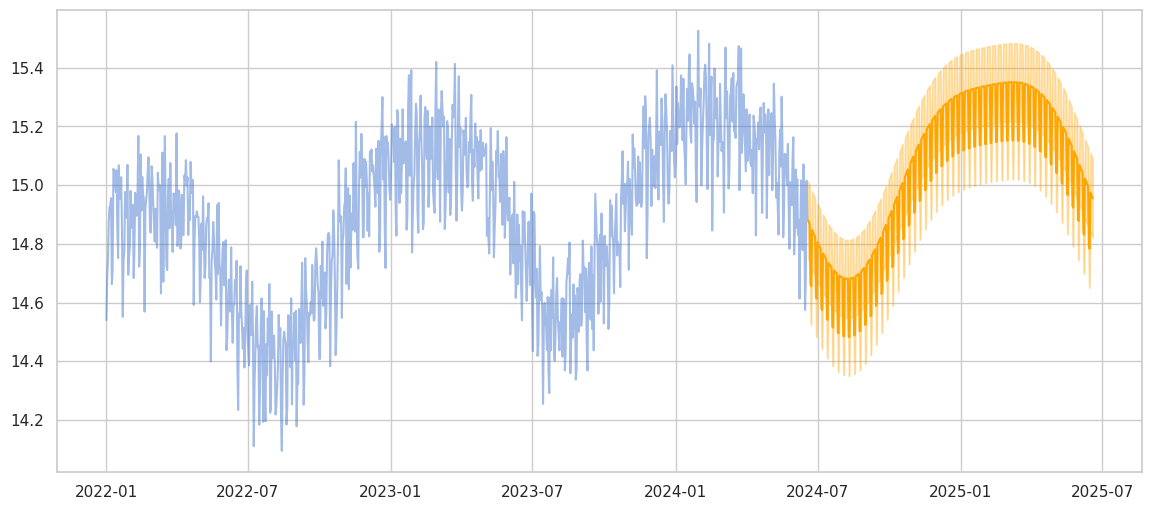

In [23]:
# %%
# Anlytic forecast

# Use our best model to predict X_future inputs and get predictions
pred = results.get_prediction(X_future)
pred_df = pred.summary_frame(alpha=0.2)  # 80% intervals
pred_df.head()
# %%
# Plot the forecast in log space 
plt.figure(figsize=(14, 6))
# Plot the actual data 
plt.plot(df_feat["date"], df_feat[y_col], label="Historical log revenue", alpha=0.5)
# Plot the forecast with prediction intervals
plt.plot(future_feat["date"], pred_df["mean"], label="Forecast log revenue", color="orange")

plt.fill_between(
    future_feat["date"],
    pred_df["obs_ci_lower"],
    pred_df["obs_ci_upper"],
    color="orange",
    alpha=0.3,
    label="80% Prediction Interval",
)

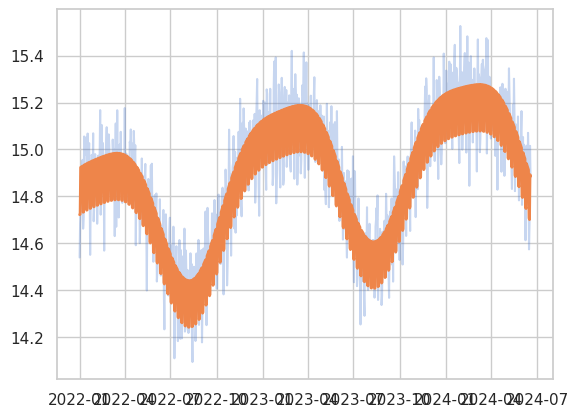

In [24]:
# %%
# Plot within sample model predictions as an extra layer of sanity check. 
df_feat["_yhat"] = results.predict(X_train)
plt.plot(df_feat["date"], df_feat[y_col], alpha=0.3)
plt.plot(df_feat["date"], df_feat["_yhat"], linewidth=2)


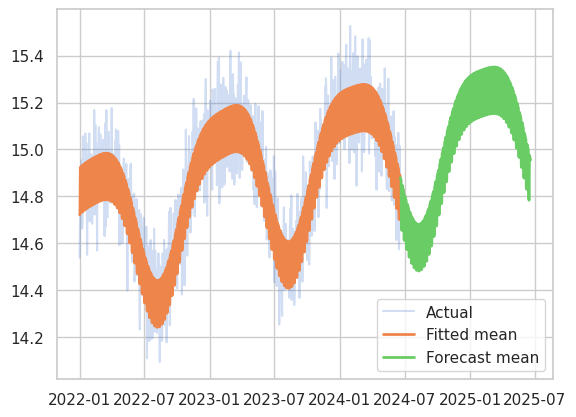

In [25]:
# %%
df_feat["_yhat_in_sample"] = results.predict(X_train)

plt.plot(df_feat["date"], df_feat[y_col], alpha=0.25, label="Actual")
plt.plot(df_feat["date"], df_feat["_yhat_in_sample"], lw=2, label="Fitted mean")
plt.plot(future_feat["date"], pred_df["mean"], lw=2, label="Forecast mean")
plt.legend()

In [26]:
# %%
# Test that errors are symmetric
down_a = pred_df["mean"] - pred_df["obs_ci_lower"]
up_a   = pred_df["obs_ci_upper"] - pred_df["mean"]

print(down_a.mean(), up_a.mean(), np.max(np.abs(down_a - up_a)))

# Now doing the bootstrap version of prediction rather than the analytic 
# version. 
from sklearn.utils import resample

def bootstrap_predictions(model, X_train, y_train, X_future, n_bootstrap=1000, confidence_level=0.8):
    """
    Generate bootstrap prediction intervals
    
    Parameters:
    - model: fitted model with coef_ and predict() methods
    - X_train, y_train: training data
    - X_future: future features to predict
    - n_bootstrap: number of bootstrap iterations
    - confidence_level: confidence level for intervals
    """
    
    # Get model parameters
    beta = model.params.values
    
    # Calculate residuals for noise sampling
    y_pred_train = model.predict(X_train)
    residuals = y_train - y_pred_train
    residual_std = np.std(residuals)
    
    # Check for statsmodels method instead
    if hasattr(model, 'cov_params'):
        param_cov = model.cov_params().values  # statsmodels
    elif hasattr(model, 'covariance_matrix_'):
        param_cov = model.covariance_matrix_   # sklearn (if available)
    else:
        param_cov = estimate_param_covariance(model, X_train, y_train, n_samples=100)
        
    # Prepare arrays for storage
    n_future = len(X_future)
    all_predictions = np.zeros((n_bootstrap, n_future))
    
    # Add intercept column to X_future if needed
    if X_future.shape[1] == len(beta) - 1:
        X_future_with_intercept = np.column_stack([np.ones(len(X_future)), X_future])
    else:
        X_future_with_intercept = X_future.copy()
    
    # Bootstrap iterations
    for i in range(n_bootstrap):
        
        # 1. Sample beta coefficients from multivariate normal
        if param_cov is not None:
            beta_sample = np.random.multivariate_normal(beta, param_cov)
        else:
            # Print a warning
            print("Warning: No parameter covariance matrix available. Using exact beta weights.")
            beta_sample = beta  # Use original if no covariance available
        
        # 2. Make predictions with sampled parameters
        # Matrix multiplication of X_future parameter values and sampled beta weights.
        pred_mean = X_future_with_intercept @ beta_sample
        
        # 3. Add residual noise
        # sample from a gaussian distribution with mean 0 and SD of the residuals
        residual_noise = np.random.normal(0, residual_std, n_future)
        
        # 4. Final prediction with uncertainty
        all_predictions[i, :] = pred_mean + residual_noise
    
    return all_predictions

def estimate_param_covariance(model, X, y, n_samples=100):
    """Estimate parameter covariance via bootstrap if not available"""
    n_params = len(model.coef_) + 1  # +1 for intercept
    param_samples = np.zeros((n_samples, n_params))
    
    for i in range(n_samples):
        X_boot, y_boot = resample(X, y, random_state=i)
        model_class = type(model)              # Get the class
        model_params = model.get_params()      # Get parameters dict
        # This ensures we use the same model type and hyperparameters from our main model
        model_boot = model_class(**model_params)  # Create new instance
        model_boot = model_boot.fit(X_boot, y_boot)  # Fit it
        # The above four lines can be done in this one, it's just harder to parse. 
        # model_boot = type(model)(**model.get_params()).fit(X_boot, y_boot)
        param_samples[i, :] = np.append(model_boot.intercept_, model_boot.coef_)
    
    return np.cov(param_samples.T)

0.13304569214943582 0.13304569214943582 0.0


In [27]:
# %%
# Usage
n_bootstrap = 1000
all_preds = bootstrap_predictions(
    model.fit(), X_train, y_train, X_future, 
    n_bootstrap=n_bootstrap, 
    confidence_level=0.8
)

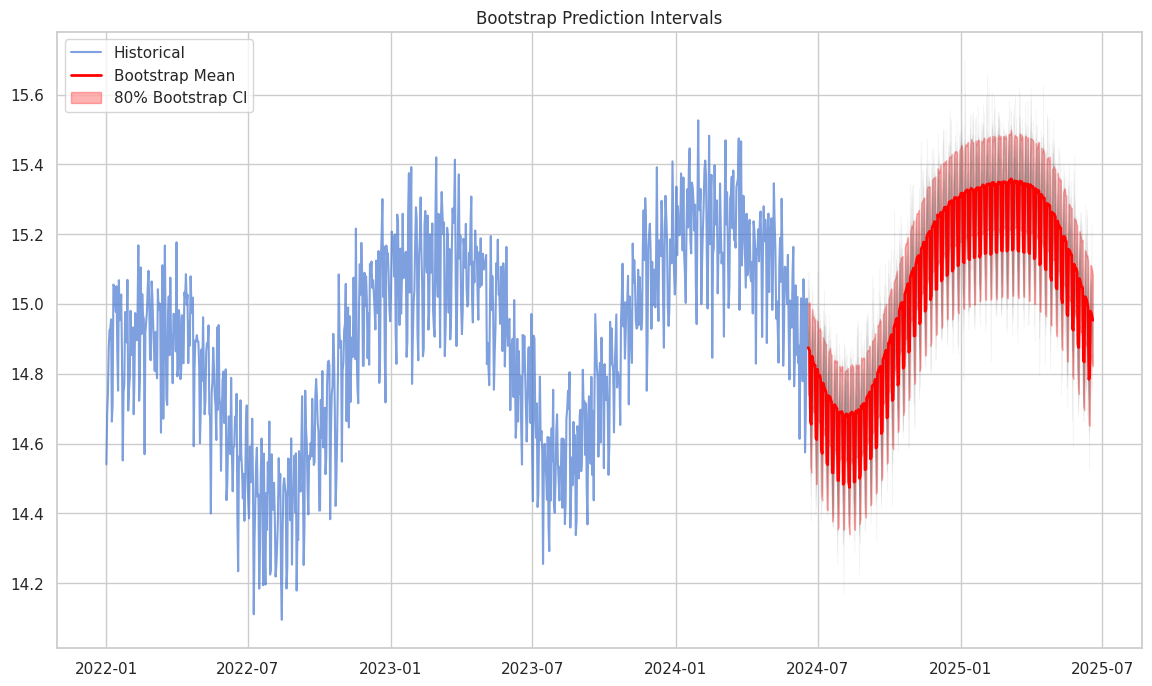

In [28]:
# %%
# Create DataFrame with all paths
future_dates = future_feat["date"]  # Adjust this to your date column
bootstrap_df = pd.DataFrame(
    all_preds.T,  # Transpose so dates are rows
    index=future_dates,
    columns=[f"bootstrap_{i}" for i in range(n_bootstrap)]
)

CI = .8
# Calculate summary statistics
alpha = (1 - CI) / 2  # For 80% CI
bootstrap_summary = pd.DataFrame({
    'date': future_dates,
    'mean': np.mean(all_preds, axis=0),
    'obs_ci_lower': np.quantile(all_preds, alpha, axis=0),
    'obs_ci_upper': np.quantile(all_preds, 1-alpha, axis=0),
    'std': np.std(all_preds, axis=0)
})


# Plot the results
plt.figure(figsize=(14, 8))

# Plot historical data
plt.plot(df_feat["date"], df_feat[y_col], label="Historical", alpha=0.7)

# Plot some bootstrap paths (sample for visibility)
for i in range(0, n_bootstrap, n_bootstrap//20):  # Plot every 20th path
    plt.plot(future_dates, all_preds[i, :], alpha=0.1, color='gray', linewidth=0.5)

# Plot bootstrap mean and CI
plt.plot(bootstrap_summary['date'], bootstrap_summary['mean'], 
         label="Bootstrap Mean", color="red", linewidth=2)

plt.fill_between(
    bootstrap_summary['date'],
    bootstrap_summary['obs_ci_lower'],
    bootstrap_summary['obs_ci_upper'],
    color="red", alpha=0.3, label="80% Bootstrap CI"
)

plt.legend()
plt.title("Bootstrap Prediction Intervals")
plt.show()

In [29]:
# %%
down = bootstrap_summary['mean'] - bootstrap_summary['obs_ci_lower']
up   = bootstrap_summary['obs_ci_upper'] - bootstrap_summary['mean']

print("avg down:", down.mean(), "avg up:", up.mean())
print("max abs diff:", np.max(np.abs(down - up)))

avg down: 0.1321820534201119 avg up: 0.13218689715761603
max abs diff: 0.01800366450136437


In [30]:
# %%
# Doing it in raw revenue space now by exponentiating the log forecasts
# Transform each individual bootstrap path to revenue space
revenue_predictions = np.exp(all_preds)

alpha = (1 - 0.8) / 2  # For 80% CI
revenue_summary = pd.DataFrame({
    'date': future_dates,
    'mean': np.mean(revenue_predictions, axis=0),           # Mean in revenue space
    'obs_ci_lower': np.quantile(revenue_predictions, alpha, axis=0),      # 10th percentile
    'obs_ci_upper': np.quantile(revenue_predictions, 1-alpha, axis=0),    # 90th percentile
    'std': np.std(revenue_predictions, axis=0)              # Std in revenue space
})

# Create DataFrame with all revenue paths (transformed)
revenue_bootstrap_df = pd.DataFrame(
    revenue_predictions.T,  # Transpose so dates are rows
    index=future_dates,
    columns=[f"bootstrap_{i}" for i in range(n_bootstrap)]
)

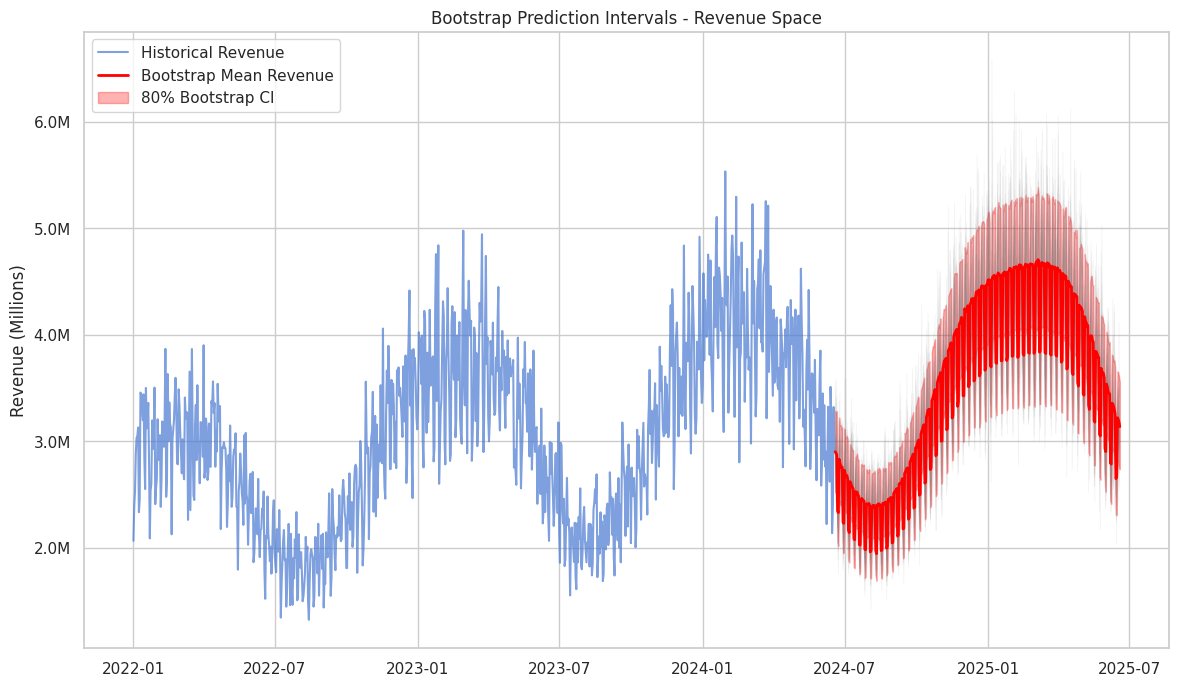

Revenue bootstrap summary:
        date          mean  obs_ci_lower  obs_ci_upper            std
0 2024-06-19  2.899976e+06  2.517892e+06  3.282954e+06  302100.602901
1 2024-06-20  2.887245e+06  2.518686e+06  3.265045e+06  292102.517344
2 2024-06-21  2.870346e+06  2.498861e+06  3.280567e+06  306938.367492
3 2024-06-22  2.345479e+06  2.053562e+06  2.645737e+06  240636.873440
4 2024-06-23  2.327933e+06  2.017414e+06  2.646783e+06  247512.104403


In [31]:
# %%
# Plot the results in revenue space
plt.figure(figsize=(14, 8))

# Plot historical data (transform from log if needed)
plt.plot(df_feat["date"], np.exp(df_feat[y_col]), label="Historical Revenue", alpha=0.7)

# Plot some bootstrap revenue paths (sample for visibility)
for i in range(0, n_bootstrap, n_bootstrap//20):  # Plot every 20th path
    plt.plot(future_dates, revenue_predictions[i, :], alpha=0.1, color='gray', linewidth=0.5)

# Plot bootstrap mean and CI in revenue space
plt.plot(revenue_summary['date'], revenue_summary['mean'], 
         label="Bootstrap Mean Revenue", color="red", linewidth=2)

plt.fill_between(
    revenue_summary['date'],
    revenue_summary['obs_ci_lower'],
    revenue_summary['obs_ci_upper'],
    color="red", alpha=0.3, label="80% Bootstrap CI"
)

# Format Y-axis to show millions
from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x/1e6:.1f}M'

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.legend()
plt.title("Bootstrap Prediction Intervals - Revenue Space")
plt.ylabel("Revenue (Millions)")
plt.show()

print("Revenue bootstrap summary:")
print(revenue_summary.head())


In [34]:
# %%
# This cell defines all the functions needed to evaluate the MAE of different
# FX volatility windows using a rolling-origin time-series cross-validation approach.


# ----------------------------
# 1) Helper: rolling-origin split generator
# ----------------------------
# Note: this is a generator function that yields train/test indices for each fold.
# Basically if step days is set to 14, you'll get a new fold (train + test data) every
# 14 days. The training data is all data up to the origin date, and the test data
# is the next horizon_days after the origin date. We dont do overlapping training windows
# because we want to simulate real forecasting as closely as possible.
def rolling_origin_splits(
    df,
    date_col="date",
    min_train_days=365,  # must have at least this much training history
    step_days=14,  # move forecast origin forward by this many days each fold
    horizon_days=30,  # predict next H days
):
    """
    Yields (train_idx, test_idx, origin_date) for a rolling-origin backtest.

    - Train uses all data up to origin_date (expanding window).
    - Test is the next 'horizon_days' after origin_date.

    Why: This respects temporal ordering and approximates real forecasting.
    """
    df = df.sort_values(date_col).reset_index(drop=True)
    dates = df[date_col]

    start_date = dates.min() + pd.Timedelta(days=min_train_days)
    last_possible_origin = dates.max() - pd.Timedelta(days=horizon_days)

    origin = start_date
    while origin <= last_possible_origin:
        train_idx = df.index[dates <= origin]
        test_idx = df.index[
            (dates > origin) & (dates <= origin + pd.Timedelta(days=horizon_days))
        ]
        if len(test_idx) > 0 and len(train_idx) > 0:
            yield train_idx, test_idx, origin
        origin += pd.Timedelta(days=step_days)


In [ ]:
# %%

def backtest_final_model(
    df,
    *,
    state,                        # contains t0, tau, log_mode etc
    feature_cols_no_const,        # ["t","is_weekend","sin_1y_1",...,"break_term"]
    date_col="date",
    y_log_col="revenue_usd_log",
    y_usd_col="revenue_usd",
    horizon_days=30,
    min_train_days=365,
    step_days=14,
    alpha=0.2,                    # 80% PI
):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    rows = []

    for fold_i, (train_idx, test_idx, origin) in enumerate(
        rolling_origin_splits(
            df, date_col=date_col,
            min_train_days=min_train_days,
            step_days=step_days,
            horizon_days=horizon_days,
        )
    ):
        train_raw = df.loc[train_idx].copy()
        test_raw  = df.loc[test_idx].copy()

        # --- Feature engineering (forecast-safe) ---
        train_feat = prepare_features(train_raw, **state, add_log=True)
        test_feat  = prepare_features(test_raw,  **state, add_log=True)

        # --- Build X/y ---
        X_train = train_feat[feature_cols_no_const].astype(float)
        y_train = train_feat[y_log_col].astype(float)

        X_test = test_feat[feature_cols_no_const].astype(float)
        y_test_log = test_feat[y_log_col].astype(float).to_numpy()
        y_test_usd = test_feat[y_usd_col].astype(float).to_numpy()

        # Add intercept (critical)
        X_train = sm.add_constant(X_train, has_constant="add")
        X_test  = sm.add_constant(X_test,  has_constant="add")

        # Fit
        res = sm.OLS(y_train, X_train).fit()

        # Predict + PI in log space
        pred = res.get_prediction(X_test)
        sf = pred.summary_frame(alpha=alpha)

        mu_log = sf["mean"].to_numpy()
        lo_log = sf["obs_ci_lower"].to_numpy()
        hi_log = sf["obs_ci_upper"].to_numpy()

        # --- Point forecasts in $ ---
        # exp(mean log) is median of lognormal. Stakeholders usually accept it.
        yhat_usd = np.exp(mu_log)
        lo_usd = np.exp(lo_log)
        hi_usd = np.exp(hi_log)

        # --- Metrics: log space ---
        ae_log = np.abs(y_test_log - mu_log)
        mae_log = ae_log.mean()
        rmse_log = np.sqrt(np.mean((y_test_log - mu_log) ** 2))

        # Interpret log MAE as a typical % error factor
        # This is possible because log(yhat) - log(y) ≈ log(yhat / y) so exp(log(yhat / y)) = yhat / y 
        # empm1 is exp(x) - 1
        typical_pct_err = np.expm1(mae_log)  # approx typical relative error

        # --- Metrics: $ space ---
        ae_usd = np.abs(y_test_usd - yhat_usd)
        mae_usd = ae_usd.mean()

        # WAPE is stakeholder-friendly
        # Sum all the absolute errors, divide by total actuals. Gives 'what percentage of total revenue did we miss by?'
        wape = ae_usd.sum() / np.maximum(y_test_usd.sum(), 1e-12)

        # Interval calibration (log)
        # What percent of the time did the actuals fall within our predicted intervals?
        covered = np.mean((y_test_log >= lo_log) & (y_test_log <= hi_log))
        avg_width_log = np.mean(hi_log - lo_log)

        # Interval calibration ($)
        covered_usd = np.mean((y_test_usd >= lo_usd) & (y_test_usd <= hi_usd))
        avg_width_usd = np.mean(hi_usd - lo_usd)

        rows.append({
            "fold": fold_i,
            "origin_date": origin,
            "n_train": len(train_feat),
            "n_test": len(test_feat),
            "mae_log": mae_log,
            "rmse_log": rmse_log,
            "typical_pct_err": typical_pct_err,   # ~ “typical % error”
            "mae_usd": mae_usd,
            "wape": wape,
            "pi80_coverage_log": covered,
            "pi80_width_log": avg_width_log,
            "pi80_coverage_usd": covered_usd,
            "pi80_width_usd": avg_width_usd,
        })

    folds = pd.DataFrame(rows)

    summary = {
        "folds": len(folds),
        "horizon_days": horizon_days,
        "mae_log_mean": folds["mae_log"].mean(),
        # Take the 90th percentile of mae_log to see how bad the worst-case typical error is
        "mae_log_p90": folds["mae_log"].quantile(0.9),
        "typical_pct_err_mean": folds["typical_pct_err"].mean(),
        "wape_mean": folds["wape"].mean(),
        "wape_p90": folds["wape"].quantile(0.9),
        "pi80_coverage_log": folds["pi80_coverage_log"].mean(),
        "pi80_coverage_usd": folds["pi80_coverage_usd"].mean(),
    }

    return folds, pd.Series(summary)

In [41]:
# %%

backtest_results, backtest_summary = backtest_final_model(
    df=df,
    state=state,
    feature_cols_no_const=[
    "t",
    "is_weekend",
    "sin_1y_1", "cos_1y_1",
    "sin_1y_2", "cos_1y_2",
    "break_term"],
    date_col="date",
    y_log_col="revenue_usd_log",
    y_usd_col="revenue_usd",
    horizon_days=90,
    min_train_days=365,
    step_days=14,
    alpha=0.2,
)

In [42]:
# %%
print("=== Backtest summary ===")
print(backtest_summary)

=== Backtest summary ===
folds                   32.000000
horizon_days            90.000000
mae_log_mean             0.096087
mae_log_p90              0.102693
typical_pct_err_mean     0.101555
wape_mean                0.094618
wape_p90                 0.104024
pi80_coverage_log        0.773958
pi80_coverage_usd        0.773958
dtype: float64


# Writeup
1) model historical revenue
2) estimate the impact of the policy change
3) forecast revenue forward under current conditions
4) communicate uncertainty and risks to stakeholders

1.
We fit a model to explain the historical data. We found that there were two strong seasonal harmonics, as well as a weekend effect (sales higher on weekends) and a strong upward trend over time. We found that while there 

2.
We 